In [14]:
#!pip install pint
#!pip install scikit-image
#!pip install opencv-python
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
from skimage import data
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pint

u = pint.UnitRegistry()
%matplotlib inline

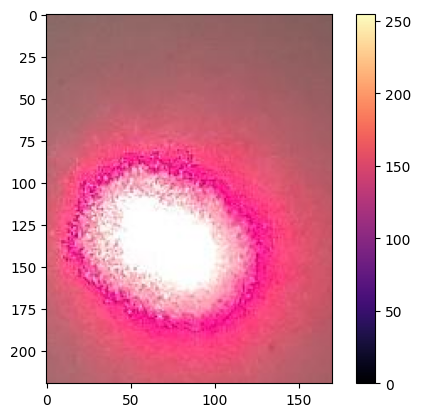

In [15]:
control = Image.open('control.png')
singleslit = Image.open('singleslit.png')
diffraction_grating = Image.open('diffraction_grating.png')
pinhole = Image.open('pinhole.png')

top = 650
bottom = 870
left = 850
right = 1020

crop_control = control.crop((left,top,right,bottom))
cmap = plt.cm.magma
plt.imshow(crop_control, cmap=cmap)
plt.colorbar()

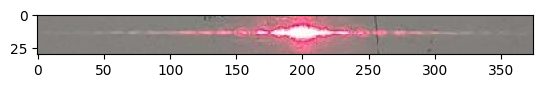

In [16]:
top = 840
bottom = 870
left = 800
right = 1175

crop_single = singleslit.crop((left,top,right,bottom))
plt.imshow(crop_single)


#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_single.png'

#crop_single.save(path)

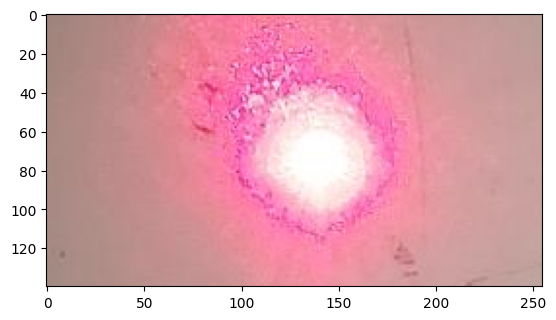

In [17]:
top = 710
bottom = 850
left = 845
right = 1100

crop_pinhole = pinhole.crop((left,top,right,bottom))
plt.imshow(crop_pinhole)

#path = 'C:\\Users\\James\\Desktop\\Optics\\Lab 3\\crop_pinhole.png'

#crop_pinhole.save(path)

In [37]:


class calculate_diffraction:

    def __init__(self,diffraction,image,top,bottom,left,right):
        self.diffraction = diffraction
        self.image = image
        self.top = top
        self.bottom = bottom
        self.left = left
        self.right = right
        
    def image_processing(self):
        string1 = 'crop_'
        string2 = '.png'
        path = string1 + self.diffraction + string2
        self.path = path
        crop = plt.imread(self.path)
        self.crop = crop
        height, w, _ = crop.shape
        self.height = height
        self.w = w
        width = right_scale-left_scale
        self.width = width
        scale_length = self.width
        self.scale_length = scale_length
        pixels_per_cm = self.scale_length
        self.pixels_per_cm = pixels_per_cm
        x_ticks = np.arange(0, self.w, self.pixels_per_cm)
        self.x_ticks = x_ticks
        
    def set_scale(self,top_scale,bottom_scale,left_scale,right_scale):
        self.top_scale = top_scale
        self.bottom_scale = bottom_scale
        self.left_scale = left_scale
        self.right_scale = right_scale
        
    def set_R(self,R):
        self.R = R
        
    def get_R(self):
        return self.R
    
    def set_D(self,D):
        self.D = D
        
    def get_D(self):
        return self.D
    
    def set_lam(self,lam):
        self.lam = lam
        k = 2*np.pi / (self.lam)
        self.k = k
        
    def get_lam(self):
        return self.lam
    
    def get_k(self):
        self.k = k
        
    def set_z(self,z):
        self.z = z
        
    def get_z(self):
        return self.z
    
    def set_h(self,h):
        self.h = h
        
    def get_h(self):
        return self.h
    
    def set_x(self,x):
        self.x = x
        xv,yv = np.meshgrid(self.x,self.x)
        self.xv = xv
        self.yv = yv
        if self.h == 'None':
            U0 = xv**2 + yv**2 < self.R**2
            U0 = U0.astype(float)
            self.U0 = U0
        elif self.R == 'None':
            U0 = (np.abs(self.xv)<self.D/2) * (np.abs(self.yv)<self.h)
            U0 = U0.astype(float)
            self.U0 = U0
    
    def get_U0(self):
        return self.U0
    
    def get_mesh(self):
        return self.xv,self.yv
    
    def get_x(self):
        return self.x
    
    def compute_U(self):
        A = fft2(self.U0)
        self.A = A
        self.kx = 2*np.pi * fftfreq(len(self.x), np.diff(self.x)[0])
        self.kxv, self.kyv = np.meshgrid(self.kx,self.kx)
        self.k = 2*np.pi/self.lam
        U = ifft2(self.A*np.exp(1j*self.z*np.sqrt(self.k**2-self.kxv**2-self.kyv**2)))
        self.U = U
    
    def plot(self):
        rows = 1
        columns = 2
        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(rows, columns, 1)
        plt.pcolormesh(self.xv,self.yv,np.abs(self.U), cmap='inferno')
        plt.xlabel('$x [cm]$')
        plt.ylabel('$y$ [cm]')
        fig.add_subplot(rows, columns, 2)
        plt.imshow(self.image)
        
        fig, ax = plt.subplots()
        ax.imshow(self.crop)
        ax.set_xticks(self.x_ticks)
        ax.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        plt.show()
        
        return plt.show()
    
    def get_minima(self):
        rows = 1
        columns = 2
        m  = np.arange(1,5,1)
        self.m = m
        x_min = np.sqrt(self.m**2 * self.lam**2 * self.z**2 / (self.D**2 - self.m**2 * self.lam**2)).to('mm')
        self.x_min = x_min
        fig = plt.figure(figsize=(10, 7))
        #fig.add_subplot(rows, columns, 1)
        plt.plot(self.x, np.abs(self.U)[250])
        [plt.axvline(self.x.magnitude, ls='--', color='r') for self.x in self.x_min]
        [plt.axvline(-self.x.magnitude, ls='--', color='r') for self.x in self.x_min]
        plt.xlabel('$x$ [cm]')
        plt.ylabel('$u(x,y,z)$ [sqrt of intensity]')
        #fig.add_subplot(rows, columns, 2)
        # Convert to grayscale if not already in grayscale
        img = self.image.convert("L")

# Compute sum of pixel values along each row
        sums = np.sum(np.array(img), axis=1)

# Find the row with the maximum sum
        y = np.argmax(sums)

# Get pixel values along the selected line
        line = [img.getpixel((x, y)) for x in range(img.width)]
        line = np.sqrt(line)

# Plot intensity vs position
        #plt.plot(line)
        #plt.xlabel("Position (pixels)")
        #plt.ylabel("Intensity")
        
        fig, ax = plt.subplots()
        ax.plot(line)
        ax.set_xticks(self.x_ticks)
        ax.set_xticklabels([f"{i // self.pixels_per_cm} cm" for i in self.x_ticks], rotation=45)
        #plt.show()
        
        return plt.show()

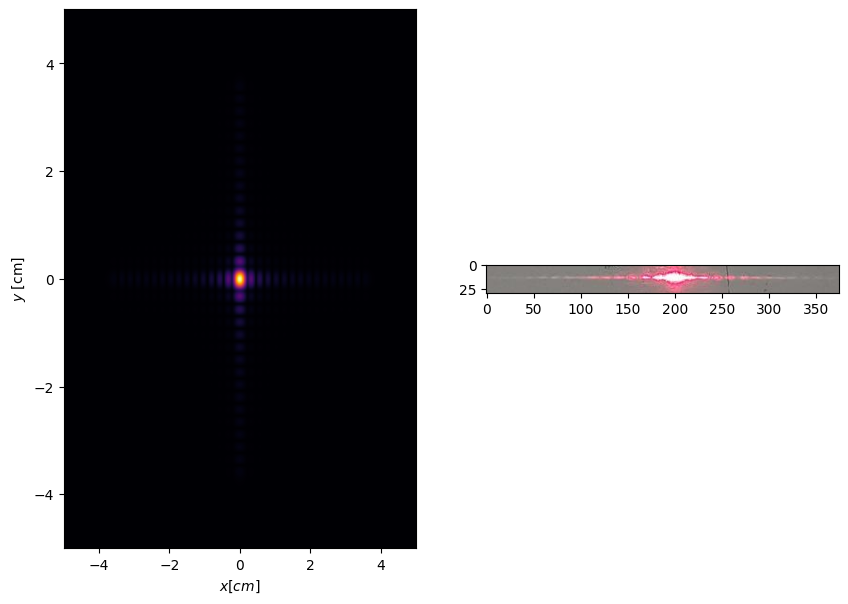

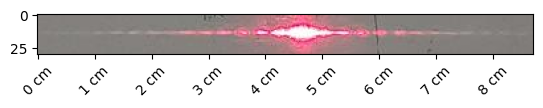

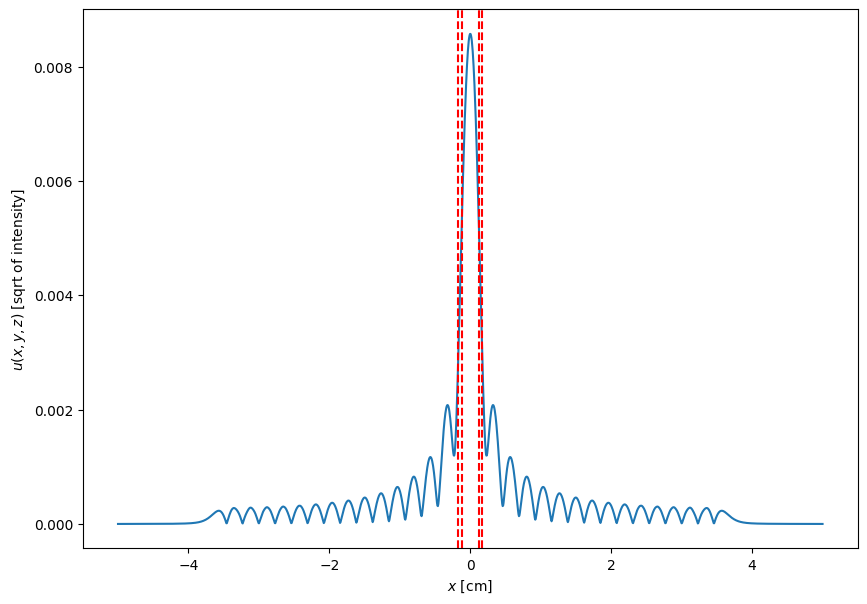

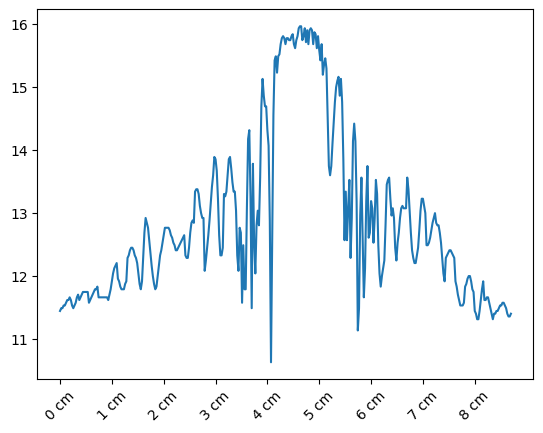

In [38]:
top = 840
bottom = 870
left = 800
right = 1175

top_scale = 400
bottom_scale = 600
left_scale = 747
right_scale = 790

#pinhole_diffraction = calculate_diffraction('pinhole',crop_pinhole,top,bottom,left,right)

single_slit = calculate_diffraction('single',crop_single,top,bottom,left,right)
single_slit.set_scale(top_scale,bottom_scale,left_scale,right_scale)
single_slit.image_processing()
single_slit.set_h(1*u.mm)
single_slit.set_R('None')
single_slit.set_lam(660 * u.nm)
single_slit.set_D(2 * u.mm)
single_slit.set_x(np.linspace(-5,5,1600) * u.cm)
single_slit.set_z(700*u.cm)
single_slit.compute_U()
single_slit.plot()
single_slit.get_minima()

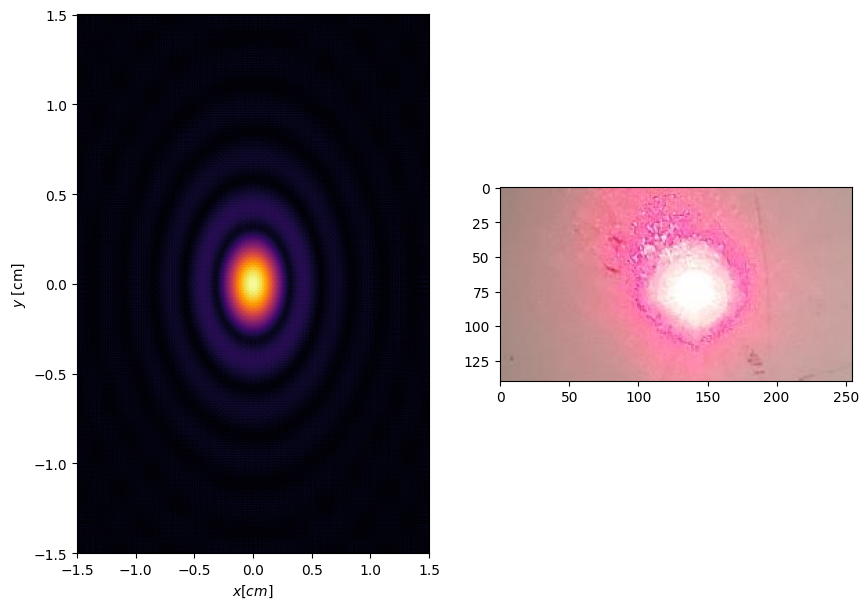

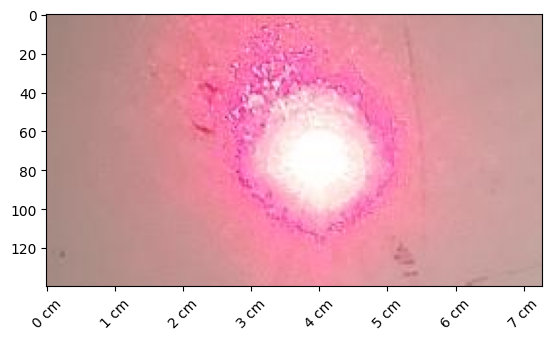

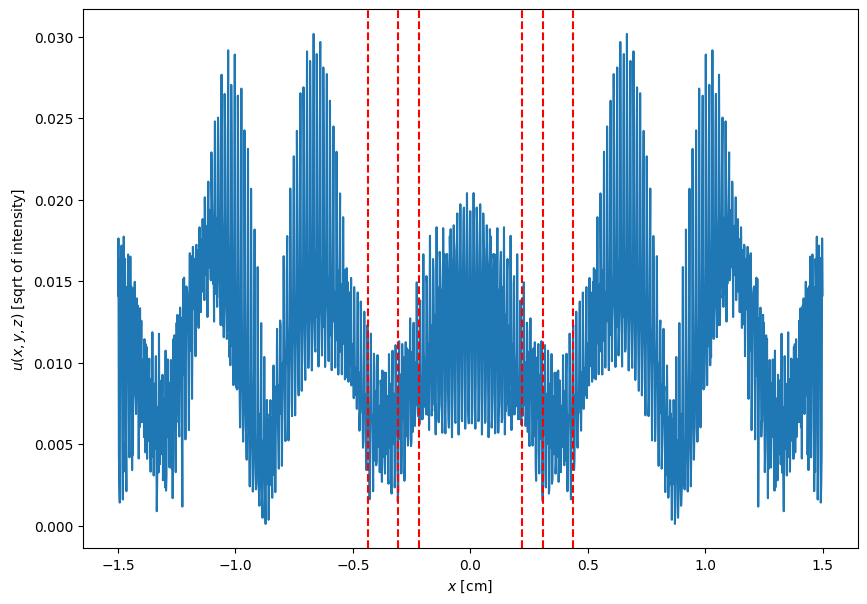

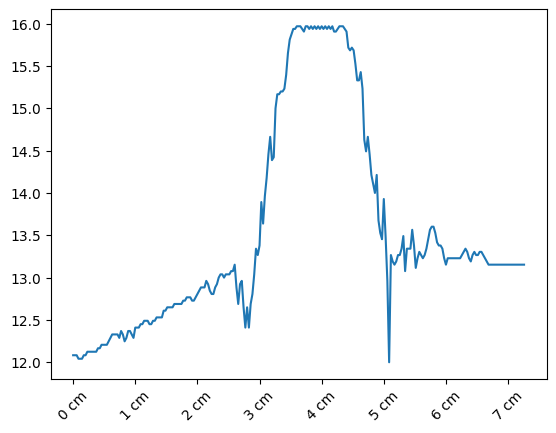

In [43]:
top = 400
bottom = 500
left = 772
right = 807

top_scale = 400
bottom_scale = 500
left_scale = 772
right_scale = 807

pinhole_diffraction = calculate_diffraction('pinhole',crop_pinhole,top,bottom,left,right)
pinhole_diffraction.set_scale(top_scale,bottom_scale,left_scale,right_scale)
pinhole_diffraction.image_processing()
pinhole_diffraction.set_R(0.8*u.mm)
pinhole_diffraction.set_h('None')
pinhole_diffraction.set_lam(600 * u.nm)
pinhole_diffraction.set_D(0.8 * u.mm)
pinhole_diffraction.get_R()
pinhole_diffraction.set_x(np.linspace(-1.5,1.5,1600) * u.cm)
pinhole_diffraction.set_z(700*u.cm)
pinhole_diffraction.compute_U()
pinhole_diffraction.plot()
pinhole_diffraction.get_minima()

In [ ]:
single_slit.scale_length

In [ ]:
        string1 = 'crop_'
        string2 = '.png'
        path = string1 + self.diffraction + string2
        self.path = path
        crop = plt.imread(self.path)
        self.crop = crop
        height, w, _ = crop.shape
        self.height = height
        self.w = w
        width = right-left
        self.width = width
        scale_length = self.width
        self.scale_length = scale_length
        pixels_per_cm = self.scale_length
        self.pixels_per_cm = pixels_per_cm
        x_ticks = np.arange(0, self.width, self.pixels_per_cm)
        self.x_ticks = x_ticks

In [ ]:
# Load image


# Convert to grayscale if not already in grayscale
img = crop_control.convert("L")

# Compute sum of pixel values along each row
sums = np.sum(np.array(img), axis=1)

# Find the row with the maximum sum
y = np.argmax(sums)

# Get pixel values along the selected line
line = [img.getpixel((x, y)) for x in range(img.width)]

# Plot intensity vs position
plt.plot(line)
plt.xlabel("Position (pixels)")
plt.ylabel("Intensity")
plt.show()

In [ ]:
top_scale = 400
bottom_scale = 600
left_scale = 747
right_scale = 790
scale_single = singleslit.crop((left,top,right,bottom))
#plt.imshow(scale_single)

width = right-left
scale_length = width
pixels_per_cm = scale_length

# Determine width and height of the image

crop_single = plt.imread('crop_single.png')
height, width, _ = crop_single.shape

# Create x-axis ticks
x_ticks = np.arange(0, width, pixels_per_cm)

# Plot the image and adjust the x-axis ticks
fig, ax = plt.subplots()
ax.imshow(crop_single)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{i // pixels_per_cm} cm" for i in x_ticks], rotation=45)
plt.show()

In [ ]:
plt.imshow(pinhole)


In [ ]:
top_scale = 400
bottom_scale = 500
left_scale = 772
right_scale = 807

scale_pinhole = pinhole.crop((left,top,right,bottom))
plt.imshow(scale_pinhole)

width = right-left
scale_length = width
pixels_per_cm = scale_length

# Determine width and height of the image

crop_pinhole = plt.imread('crop_pinhole.png')
height, width, _ = crop_pinhole.shape

# Create x-axis ticks
x_ticks = np.arange(0, width, pixels_per_cm)

# Plot the image and adjust the x-axis ticks
fig, ax = plt.subplots()
ax.imshow(crop_pinhole)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{i // pixels_per_cm} cm" for i in x_ticks], rotation=45)
plt.show()

In [ ]:
pinhole